In [1]:
# Importing Packages and Libraries
import shap
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sns


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# 1. Feature Preperation

In [2]:
# Load data
file_path = '/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Hedonic_Final_Cleaned.csv'
df = pd.read_csv(file_path)

In [3]:
# Create a new column 'helpful' based on reviews being helfpul or not helpful
df['helpful'] = (df['helpful_vote'] > 0).astype(int)

In [4]:
# Define features and target
features = ['RewExt','Sentiment','Subjective', 'WordC', 'SentC', 'SentL', 'TitleL', 'ElapDays',
            'Image', 'VerPur', 'NounR', 'AdjR', 'AdvR', 'FRE','RatingC']
target = 'helpful'



# Initialize X and y
X = df[features]
y = df[target]

# Initialize ColumnTransformer for scaling numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), features)  # Scale numerical features
    ],
)

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)

# Convert the transformed data back to a DataFrame
X = pd.DataFrame(X_preprocessed, columns=features)


# 2 Train/Test Split with Stratified K-Fold Cross-validation for Unbalanced Dataset

In [5]:
## Perform stratified K-fold cross-validation for classification with a combined stratification column 'stratify' to ensure balanced class distribution in each fold
# This column is created by combining 'helpful' and 'Prod' columns as strings.
# It uses StratifiedKFold with 10 splits, ensuring each fold preserves the percentage of samples for each class label (product and helpfulness).

from sklearn.model_selection import StratifiedKFold

# Create a combined column for stratification
df['stratify'] = df['helpful'].astype(str) + "_" + df['Prod'].astype(str)

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

stratify = df['stratify']

# Splitting the data
for train_index, test_index in skf.split(X, stratify):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Print the shapes of the resulting splits to check
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)

    # Optionally, you can check the distribution in each split
    print("Train stratify distribution:\n", y_train.value_counts(normalize=True))
    print("Test stratify distribution:\n", y_test.value_counts(normalize=True))

X_train shape: (16610, 15)
X_test shape: (1846, 15)
y_train shape: (16610,)
y_test shape: (1846,)
Train stratify distribution:
 helpful
0    0.831306
1    0.168694
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.830986
1    0.169014
Name: proportion, dtype: float64
X_train shape: (16610, 15)
X_test shape: (1846, 15)
y_train shape: (16610,)
y_test shape: (1846,)
Train stratify distribution:
 helpful
0    0.831246
1    0.168754
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.831528
1    0.168472
Name: proportion, dtype: float64
X_train shape: (16610, 15)
X_test shape: (1846, 15)
y_train shape: (16610,)
y_test shape: (1846,)
Train stratify distribution:
 helpful
0    0.831306
1    0.168694
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.830986
1    0.169014
Name: proportion, dtype: float64
X_train shape: (16610, 15)
X_test shape: (1846, 15)
y_train shape: (16610,)
y_test shape: (1846,)
Train stratify di

## 2.1 Data Augmentation 

In [6]:
# Applying SMOTE to the training data to ensure balanced class distribution

from imblearn.over_sampling import SMOTE

# Apply SMOTE to X_train and y_train
smote = SMOTE(random_state=42,sampling_strategy={1: 8000})
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


# Check the class distribution before resampling
print("Class distribution before SMOTE:")
print(pd.Series(y_train).value_counts())

# Check the class distribution after resampling
print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())


Class distribution before SMOTE:
helpful
0    13808
1     2803
Name: count, dtype: int64
Class distribution after SMOTE:
helpful
0    13808
1     8000
Name: count, dtype: int64


# 3. Model Building 

## 3.1 Logistic Regression

In [7]:
#Using Logistic Regression as Baseline Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Initialize the logistic regression model
logreg_model = LogisticRegression(solver='sag', max_iter=1000)  # You can adjust max_iter as needed

# Train the model
logreg_model.fit(X_train_balanced, y_train_balanced)

# Predict on the testing set
y_pred = logreg_model.predict(X_test)

# Evaluate the model
print("\nLogistic Regression Model Evaluation:")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

# Generate classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['Logistic Regression'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

LR_results = pd.DataFrame(results_dict)


Logistic Regression Model Evaluation:
Accuracy: 0.816260162601626
F1 Score: 0.4694835680751174
AUC: 0.6831393033365893
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1534
           1       0.46      0.48      0.47       311

    accuracy                           0.82      1845
   macro avg       0.68      0.68      0.68      1845
weighted avg       0.82      0.82      0.82      1845

[[1356  178]
 [ 161  150]]


## 3.2 Random Forest

In [8]:
# Using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix

# Initialize the logistic regression model
RF_model = RandomForestClassifier()  # You can adjust max_iter as needed

# Train the model
RF_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = RF_model.predict(X_test)


print("\nRandom Forest Model Evaluation:")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

# Generate classification report
print(classification_report(y_test, y_pred))

# Generate confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)





Random Forest Model Evaluation:
Accuracy: 0.8780487804878049
F1 Score: 0.5283018867924528
AUC: 0.6895345376189019
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1534
           1       0.76      0.41      0.53       311

    accuracy                           0.88      1845
   macro avg       0.82      0.69      0.73      1845
weighted avg       0.87      0.88      0.86      1845

[[1494   40]
 [ 185  126]]


## 3.2 Extreme Gradient Boosting

In [9]:
# Starting of with unbalanced data (No SMOTE applied) to evaluate improvement due to SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# Train model with default hyperparameters
xgb_cls_default = xgb.XGBClassifier()

xgb_cls_default.fit(X_train, y_train)

# Predictions on test data
y_pred_default = xgb_cls_default.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\nDefault XGBoost Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_default)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_default)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_default, X_train, y_train, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['XGBoost Default'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

XGB_Default_results = pd.DataFrame(results_dict)



Default XGBoost Evaluation:
Accuracy: 0.8720867208672086
F1 Score: 0.5461538461538461
AUC: 0.7064574887753262
Confusion Matrix:
[[1467   67]
 [ 169  142]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1534
           1       0.68      0.46      0.55       311

    accuracy                           0.87      1845
   macro avg       0.79      0.71      0.74      1845
weighted avg       0.86      0.87      0.86      1845

Mean Cross-Validated Accuracy: 0.7905577911634434


In [10]:
# Train model with SMOTE balanced data
xgb_cls_SMOTE = xgb.XGBClassifier()

xgb_cls_SMOTE.fit(X_train_balanced, y_train_balanced)

# Predictions on test data
y_pred_SMOTE = xgb_cls_SMOTE.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_SMOTE)
conf_matrix = confusion_matrix(y_test, y_pred_SMOTE)
cls_report = classification_report(y_test, y_pred_SMOTE)

print("\SMOTE Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_SMOTE)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_SMOTE)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_SMOTE, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['XGBoost SMOTE'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

XGB_results = pd.DataFrame(results_dict)

\SMOTE Model Evaluation:
Accuracy: 0.8628726287262872
F1 Score: 0.5645438898450946
AUC: 0.7291153992881607
Confusion Matrix:
[[1428  106]
 [ 147  164]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1534
           1       0.61      0.53      0.56       311

    accuracy                           0.86      1845
   macro avg       0.76      0.73      0.74      1845
weighted avg       0.86      0.86      0.86      1845

Mean Cross-Validated Accuracy: 0.723971803765631


### 3.2.1 XGradBoost Hyperparameter Tuning

In [11]:
# import packages for hyperparameters tuning with hyperopt (Bayesian Optimization)

# Define Search Space for hyperparameters
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 20, 1),
        'gamma': hp.uniform ('gamma', 0,5),
        'reg_lambda' : hp.uniform('reg_lambda', 0,10),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.3,1),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
        'seed': 0
    }

# Define the objective function, objective function: Takes space as input (hyperparameters to optimize). Returns loss to minimize
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =int(space['n_estimators']), 
                    max_depth = int(space['max_depth']), 
                    gamma = int(space['gamma']),
                    reg_lambda = int(space['reg_lambda']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=(space['colsample_bytree']))
    
    evaluation = [( X_train_balanced, y_train_balanced), ( X_test, y_test)]
    
    clf.fit(X_train_balanced, y_train_balanced,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [12]:
# Running Bayesian Optimization

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                 
0.8612466124661247                                     
  1%|          | 1/100 [00:00<00:34,  2.88trial/s, best loss: -0.8612466124661247]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8585365853658536                                                                
  2%|▏         | 2/100 [00:00<00:29,  3.30trial/s, best loss: -0.8612466124661247]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8547425474254743                                                                
  3%|▎         | 3/100 [00:00<00:25,  3.78trial/s, best loss: -0.8612466124661247]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8628726287262872                                                                
SCORE:                                                                            
0.8634146341463415                                                                
  5%|▌         | 5/100 [00:01<00:27,  3.50trial/s, best loss: -0.8634146341463415]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8644986449864499                                                                
SCORE:                                                                            
0.8558265582655826                                                                
  7%|▋         | 7/100 [00:01<00:22,  4.21trial/s, best loss: -0.8644986449864499]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8601626016260162                                                                
  8%|▊         | 8/100 [00:02<00:21,  4.35trial/s, best loss: -0.8644986449864499]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8607046070460704                                                                
  9%|▉         | 9/100 [00:02<00:21,  4.14trial/s, best loss: -0.8644986449864499]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8628726287262872                                                                
SCORE:                                                                             
0.8590785907859079                                                                 
 11%|█         | 11/100 [00:02<00:22,  3.98trial/s, best loss: -0.8644986449864499]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8666666666666667                                                                 
 12%|█▏        | 12/100 [00:03<00:21,  4.16trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8682926829268293                                                                 
 13%|█▎        | 13/100 [00:03<00:20,  4.24trial/s, best loss: -0.8682926829268293]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.865040650406504                                                                  
SCORE:                                                                             
0.8693766937669377                                                                 
 15%|█▌        | 15/100 [00:03<00:19,  4.47trial/s, best loss: -0.8693766937669377]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8634146341463415                                                                 
 16%|█▌        | 16/100 [00:04<00:19,  4.31trial/s, best loss: -0.8693766937669377]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8661246612466125                                                                 
SCORE:                                                                             
0.8688346883468835                                                                 
 18%|█▊        | 18/100 [00:04<00:18,  4.52trial/s, best loss: -0.8693766937669377]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8639566395663957                                                                 
 19%|█▉        | 19/100 [00:04<00:18,  4.47trial/s, best loss: -0.8693766937669377]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8628726287262872                                                                 
SCORE:                                                                             
0.8720867208672086                                                                 
 21%|██        | 21/100 [00:05<00:17,  4.44trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8688346883468835                                                                 
SCORE:                                                                             
0.8601626016260162                                                                 
 23%|██▎       | 23/100 [00:05<00:17,  4.50trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8623306233062331                                                                 
 24%|██▍       | 24/100 [00:06<00:21,  3.58trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8639566395663957                                                                 
SCORE:                                                                             
0.8634146341463415                                                                 
 26%|██▌       | 26/100 [00:06<00:18,  3.93trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8482384823848238                                                                 
 27%|██▋       | 27/100 [00:06<00:17,  4.15trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8601626016260162                                                                 
 28%|██▊       | 28/100 [00:06<00:17,  4.11trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8601626016260162                                                                 
 29%|██▉       | 29/100 [00:07<00:17,  4.01trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8634146341463415                                                                 
 30%|███       | 30/100 [00:07<00:18,  3.70trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.865040650406504                                                                  
 31%|███       | 31/100 [00:07<00:18,  3.79trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8590785907859079                                                                 
 32%|███▏      | 32/100 [00:08<00:18,  3.67trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8661246612466125                                                                 
 33%|███▎      | 33/100 [00:08<00:17,  3.80trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8579945799457994                                                                 
SCORE:                                                                             
0.8639566395663957                                                                 
 35%|███▌      | 35/100 [00:08<00:15,  4.21trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8655826558265582                                                                 
 36%|███▌      | 36/100 [00:09<00:20,  3.07trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8607046070460704                                                                 
SCORE:                                                                             
0.8672086720867209                                                                 
 38%|███▊      | 38/100 [00:09<00:16,  3.69trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8655826558265582                                                                 
SCORE:                                                                             
0.8644986449864499                                                                 
 40%|████      | 40/100 [00:10<00:14,  4.17trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8661246612466125                                                                 
 41%|████      | 41/100 [00:10<00:16,  3.61trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8596205962059621                                                                 
SCORE:                                                                             
0.8644986449864499                                                                 
 43%|████▎     | 43/100 [00:11<00:14,  3.83trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8634146341463415                                                                 
 44%|████▍     | 44/100 [00:11<00:13,  4.03trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8585365853658536                                                                 
 45%|████▌     | 45/100 [00:11<00:14,  3.69trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8585365853658536                                                                 
SCORE:                                                                             
0.8612466124661247                                                                 
 47%|████▋     | 47/100 [00:12<00:13,  3.97trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8661246612466125                                                                 
 48%|████▊     | 48/100 [00:12<00:14,  3.49trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.867750677506775                                                                  
 49%|████▉     | 49/100 [00:12<00:13,  3.68trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8601626016260162                                                                 
SCORE:                                                                             
0.8525745257452575                                                                 
 51%|█████     | 51/100 [00:13<00:12,  3.88trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8585365853658536                                                                 
SCORE:                                                                             
0.8666666666666667                                                                 
 53%|█████▎    | 53/100 [00:13<00:10,  4.33trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.870460704607046                                                                  
SCORE:                                                                             
0.8628726287262872                                                                 
 55%|█████▌    | 55/100 [00:14<00:09,  4.58trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8558265582655826                                                                 
SCORE:                                                                             
0.8710027100271003                                                                 
 57%|█████▋    | 57/100 [00:14<00:09,  4.77trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8666666666666667                                                                 
 58%|█████▊    | 58/100 [00:14<00:09,  4.64trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8590785907859079                                                                 
 59%|█████▉    | 59/100 [00:14<00:09,  4.53trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8617886178861789                                                                 
 60%|██████    | 60/100 [00:15<00:09,  4.27trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8531165311653116                                                                 
 61%|██████    | 61/100 [00:15<00:09,  3.90trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8617886178861789                                                                 
 62%|██████▏   | 62/100 [00:15<00:10,  3.77trial/s, best loss: -0.8720867208672086]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8682926829268293                                                                 
SCORE:                                                                             
0.8764227642276423                                                                 
 64%|██████▍   | 64/100 [00:16<00:08,  4.29trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8596205962059621                                                                 
SCORE:                                                                             
0.8764227642276423                                                                 
 66%|██████▌   | 66/100 [00:16<00:07,  4.40trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8579945799457994                                                                 
 67%|██████▋   | 67/100 [00:16<00:08,  3.83trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8536585365853658                                                                 
 68%|██████▊   | 68/100 [00:17<00:09,  3.45trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8661246612466125                                                                 
SCORE:                                                                             
 69%|██████▉   | 69/100 [00:17<00:09,  3.37trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



0.867750677506775                                                                  
 70%|███████   | 70/100 [00:17<00:08,  3.61trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8639566395663957                                                                 
 71%|███████   | 71/100 [00:18<00:07,  3.69trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8617886178861789                                                                 
SCORE:                                                                             
0.8764227642276423                                                                 
 73%|███████▎  | 73/100 [00:18<00:06,  4.13trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8764227642276423                                                                 
SCORE:                                                                             
0.8612466124661247                                                                 
 75%|███████▌  | 75/100 [00:18<00:05,  4.45trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8634146341463415                                                                 
 76%|███████▌  | 76/100 [00:19<00:05,  4.38trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8585365853658536                                                                 
 77%|███████▋  | 77/100 [00:19<00:05,  4.28trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8596205962059621                                                                 
 78%|███████▊  | 78/100 [00:19<00:06,  3.58trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8601626016260162                                                                 
 79%|███████▉  | 79/100 [00:20<00:06,  3.26trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8644986449864499                                                                 
 80%|████████  | 80/100 [00:20<00:05,  3.34trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8547425474254743                                                                 
SCORE:                                                                             
0.8655826558265582                                                                 
 82%|████████▏ | 82/100 [00:21<00:04,  3.71trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:
0.8596205962059621                                                                 
SCORE:                                                                             
0.8693766937669377                                                                 
 84%|████████▍ | 84/100 [00:21<00:03,  4.21trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8688346883468835                                                                 
 85%|████████▌ | 85/100 [00:21<00:03,  4.00trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.865040650406504                                                                  
 86%|████████▌ | 86/100 [00:22<00:03,  3.72trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8644986449864499                                                                 
 87%|████████▋ | 87/100 [00:22<00:03,  3.47trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8569105691056911                                                                 
 88%|████████▊ | 88/100 [00:22<00:03,  3.44trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8634146341463415                                                                 
 89%|████████▉ | 89/100 [00:22<00:03,  3.57trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.846070460704607                                                                  
 90%|█████████ | 90/100 [00:23<00:02,  3.61trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8628726287262872                                                                 
 91%|█████████ | 91/100 [00:23<00:02,  3.66trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8634146341463415                                                                 
 92%|█████████▏| 92/100 [00:23<00:02,  3.74trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8558265582655826                                                                 
SCORE:                                                                             
 93%|█████████▎| 93/100 [00:24<00:02,  3.10trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



0.8617886178861789                                                                 
 94%|█████████▍| 94/100 [00:24<00:01,  3.35trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8612466124661247                                                                 
 95%|█████████▌| 95/100 [00:24<00:01,  3.29trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8612466124661247                                                                 
 96%|█████████▌| 96/100 [00:25<00:01,  3.16trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8607046070460704                                                                 
 97%|█████████▋| 97/100 [00:25<00:00,  3.15trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8666666666666667                                                                 
 98%|█████████▊| 98/100 [00:25<00:00,  2.86trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8585365853658536                                                                 
 99%|█████████▉| 99/100 [00:26<00:00,  2.83trial/s, best loss: -0.8764227642276423]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8661246612466125                                                                 
100%|██████████| 100/100 [00:26<00:00,  3.77trial/s, best loss: -0.8764227642276423]
The best hyperparameters are :  

{'colsample_bytree': 0.9377909840464776, 'gamma': 3.3041554524080694, 'max_depth': 20.0, 'min_child_weight': 4.0, 'n_estimators': 400.0, 'reg_lambda': 6.344898321534086}


In [13]:
best_hyperparams = {'colsample_bytree': 0.6294341208375074, 'gamma': 3.3191551562672967, 'max_depth': 15, 'min_child_weight': 2, 'n_estimators': 350, 'reg_lambda': 4.421114602989632}


In [14]:
# With considering inbalanced data applying Weighted XGBoost
# Calculate class distribution

from collections import Counter
sqrt = np.sqrt

# Count the class distribution in the training set
counts = y_train_balanced.value_counts()
count_of_zeros = counts[0]
count_of_ones = counts[1]

# Calculate scale_pos_weight
weight_ratio = int(sqrt(count_of_zeros /count_of_ones))

print("Class distribution in the training set:", counts)
print("scale_pos_weight:", weight_ratio)

Class distribution in the training set: helpful
0    13808
1     8000
Name: count, dtype: int64
scale_pos_weight: 1


In [15]:
# Train model with modified hyperparameters
xgb_cls_hyp = xgb.XGBClassifier(**best_hyperparams, scale_pos_weight=weight_ratio)

xgb_cls_hyp.fit(X_train_balanced, y_train_balanced)

# Predictions on test data
y_pred_opt = xgb_cls_hyp.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_opt)
conf_matrix = confusion_matrix(y_test, y_pred_opt)
cls_report = classification_report(y_test, y_pred_opt)

print("\nSMOTE-Hyp Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_opt)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_opt)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_hyp, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['XGBoost with Hyperparameters'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

XGB_Hyp_results = pd.DataFrame(results_dict)


SMOTE-Hyp Model Evaluation:
Accuracy: 0.8737127371273713
F1 Score: 0.5919439579684763
AUC: 0.7420431631151563
Confusion Matrix:
[[1443   91]
 [ 142  169]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1534
           1       0.65      0.54      0.59       311

    accuracy                           0.87      1845
   macro avg       0.78      0.74      0.76      1845
weighted avg       0.87      0.87      0.87      1845

Mean Cross-Validated Accuracy: 0.7105365058407642


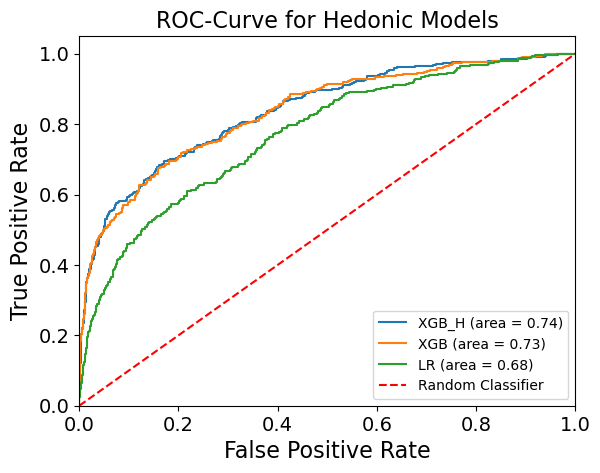

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate ROC AUC and curves for xgb_cls_hyp
logit_roc_auc_hyp = roc_auc_score(y_test, xgb_cls_hyp.predict(X_test))
fpr_hyp, tpr_hyp, thresholds_hyp = roc_curve(y_test, xgb_cls_hyp.predict_proba(X_test)[:,1])

# Calculate ROC AUC and curves for logreg_model
logit_roc_auc_logreg = roc_auc_score(y_test, logreg_model.predict(X_test))
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, logreg_model.predict_proba(X_test)[:,1])

# Calculate ROC AUC and curves for xgb_cls_SMOTE
logit_roc_auc_smote = roc_auc_score(y_test, xgb_cls_SMOTE.predict(X_test))
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, xgb_cls_SMOTE.predict_proba(X_test)[:,1])

# Plotting the ROC curves
plt.figure()
plt.plot(fpr_hyp, tpr_hyp, label='XGB_H (area = %0.2f)' % logit_roc_auc_hyp)
plt.plot(fpr_smote, tpr_smote, label='XGB (area = %0.2f)' % logit_roc_auc_smote)
plt.plot(fpr_logreg, tpr_logreg, label='LR (area = %0.2f)' % logit_roc_auc_logreg)
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier ')

# Setting plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase major tick label size
plt.tick_params(axis='both', which='minor', labelsize=14)  # Increase minor tick label size
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC-Curve for Hedonic Models', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('combined_ROC_Hedonic',dpi=400)
plt.show()


# 4. Model Comparision

In [17]:
results = pd.concat([LR_results, XGB_Default_results, XGB_results, XGB_Hyp_results], axis=0)
print(results)

                          Model  Accuracy  F1 Score       AUC
0           Logistic Regression  0.816260  0.469484  0.683139
0               XGBoost Default  0.872087  0.546154  0.706457
0                 XGBoost SMOTE  0.862873  0.564544  0.729115
0  XGBoost with Hyperparameters  0.873713  0.591944  0.742043




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



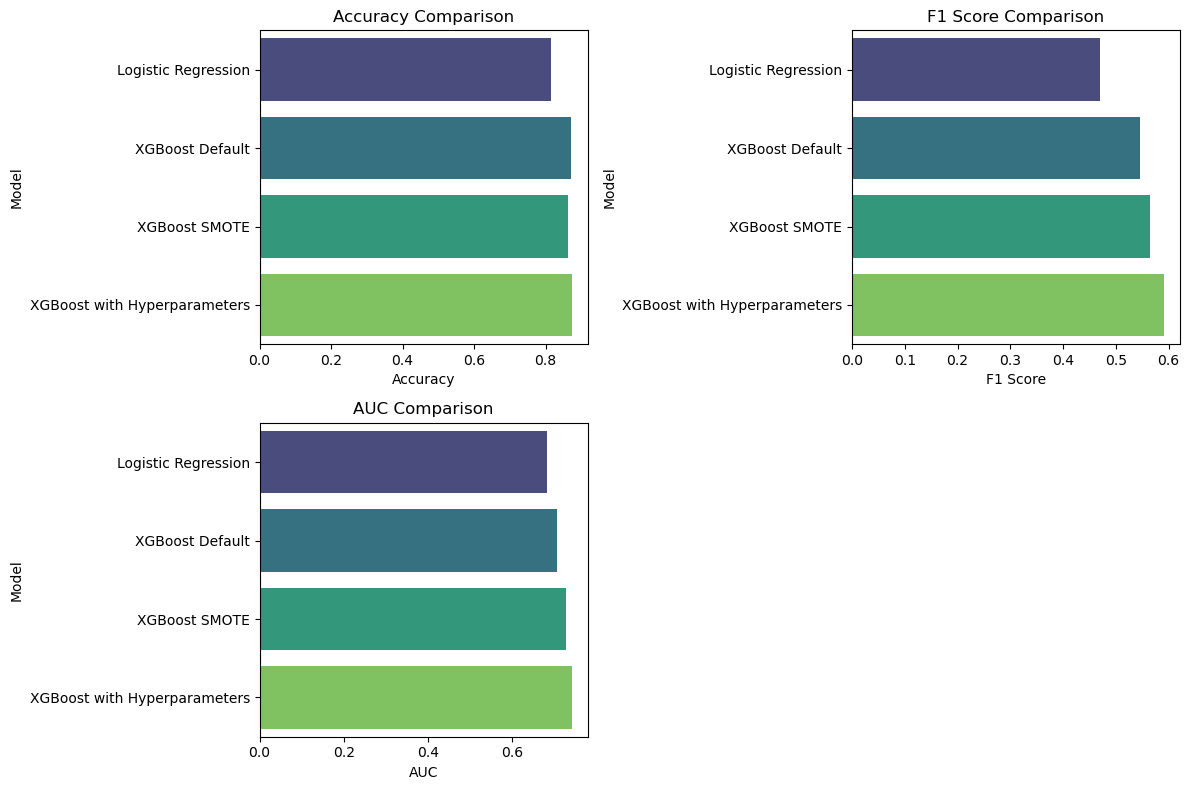

In [18]:
# Plotting the comparison
plt.figure(figsize=(12, 8))

# Plot 1: Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Accuracy', y='Model', data=results, palette='viridis')
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')

# Plot 2: F1 Score
plt.subplot(2, 2, 2)
sns.barplot(x='F1 Score', y='Model', data=results, palette='viridis')
plt.title('F1 Score Comparison')
plt.xlabel('F1 Score')

# Plot 3: AUC
plt.subplot(2, 2, 3)
sns.barplot(x='AUC', y='Model', data=results, palette='viridis')
plt.title('AUC Comparison')
plt.xlabel('AUC')


plt.tight_layout()
plt.show()

# 5. Feature Importance with Shap Values

[08:32:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 99%|===================| 21639/21808 [00:47<00:00]        

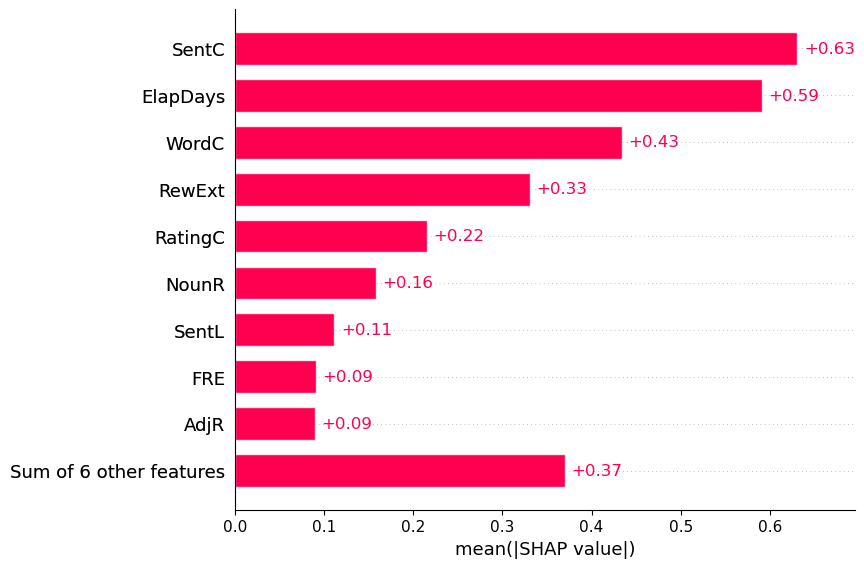

In [19]:
explainer = shap.TreeExplainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

shap.plots.bar(shap_values.abs.mean(0))

[10:08:47] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 99%|===================| 21564/21808 [00:26<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


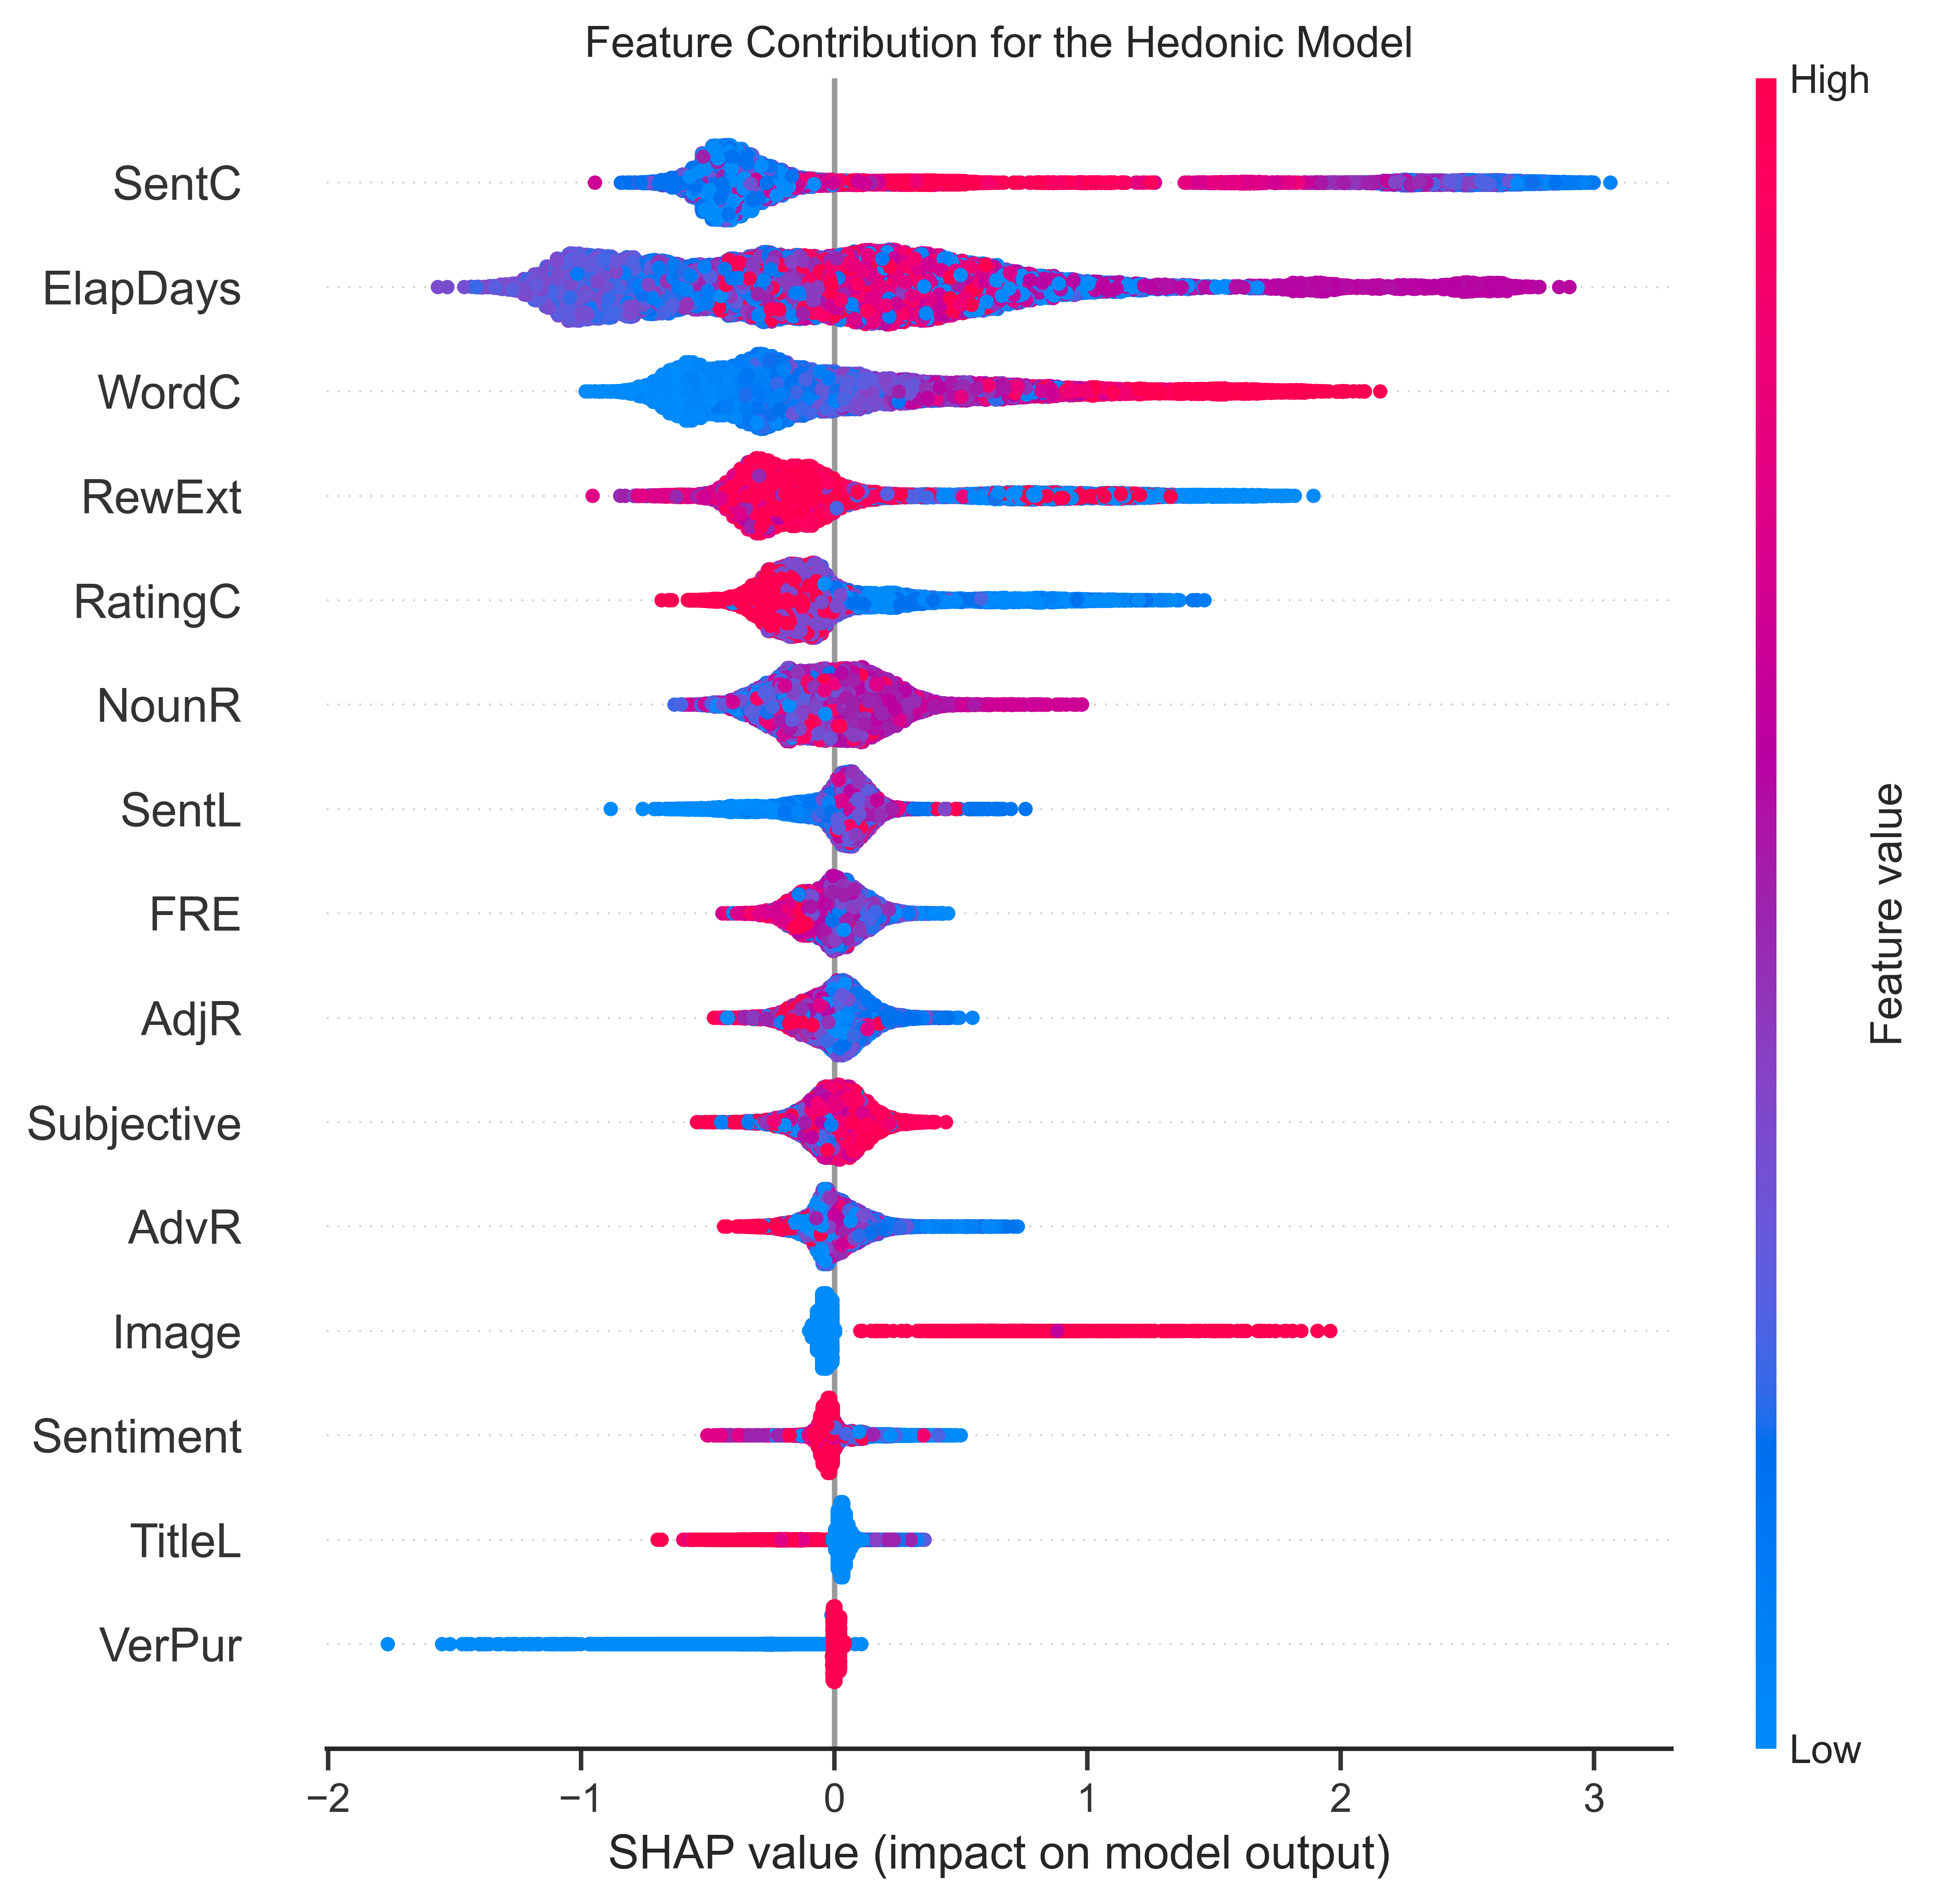

In [29]:
sns.set(style='white')
# Compute SHAP values
explainer = shap.TreeExplainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

# Create a beeswarm plot with increased quality
fig, ax = plt.subplots(figsize=(6, 8), dpi=600)  # Set figure size and DPI

# Set figure size and DPI
shap.plots.beeswarm(shap_values, max_display=15, show=False)  # Create the plot without displaying it immediately

# Add title to the plot
plt.title('Feature Contribution for the Hedonic Model')

plt.tight_layout()  # Adjust the layout to prevent clipping

# Save the plot to a file with high resolution
#plt.savefig('shap_beeswarm_plot_Hedonic.png', dpi=800)  # Save the figure with the desired DPI

# Display the plot
plt.show()

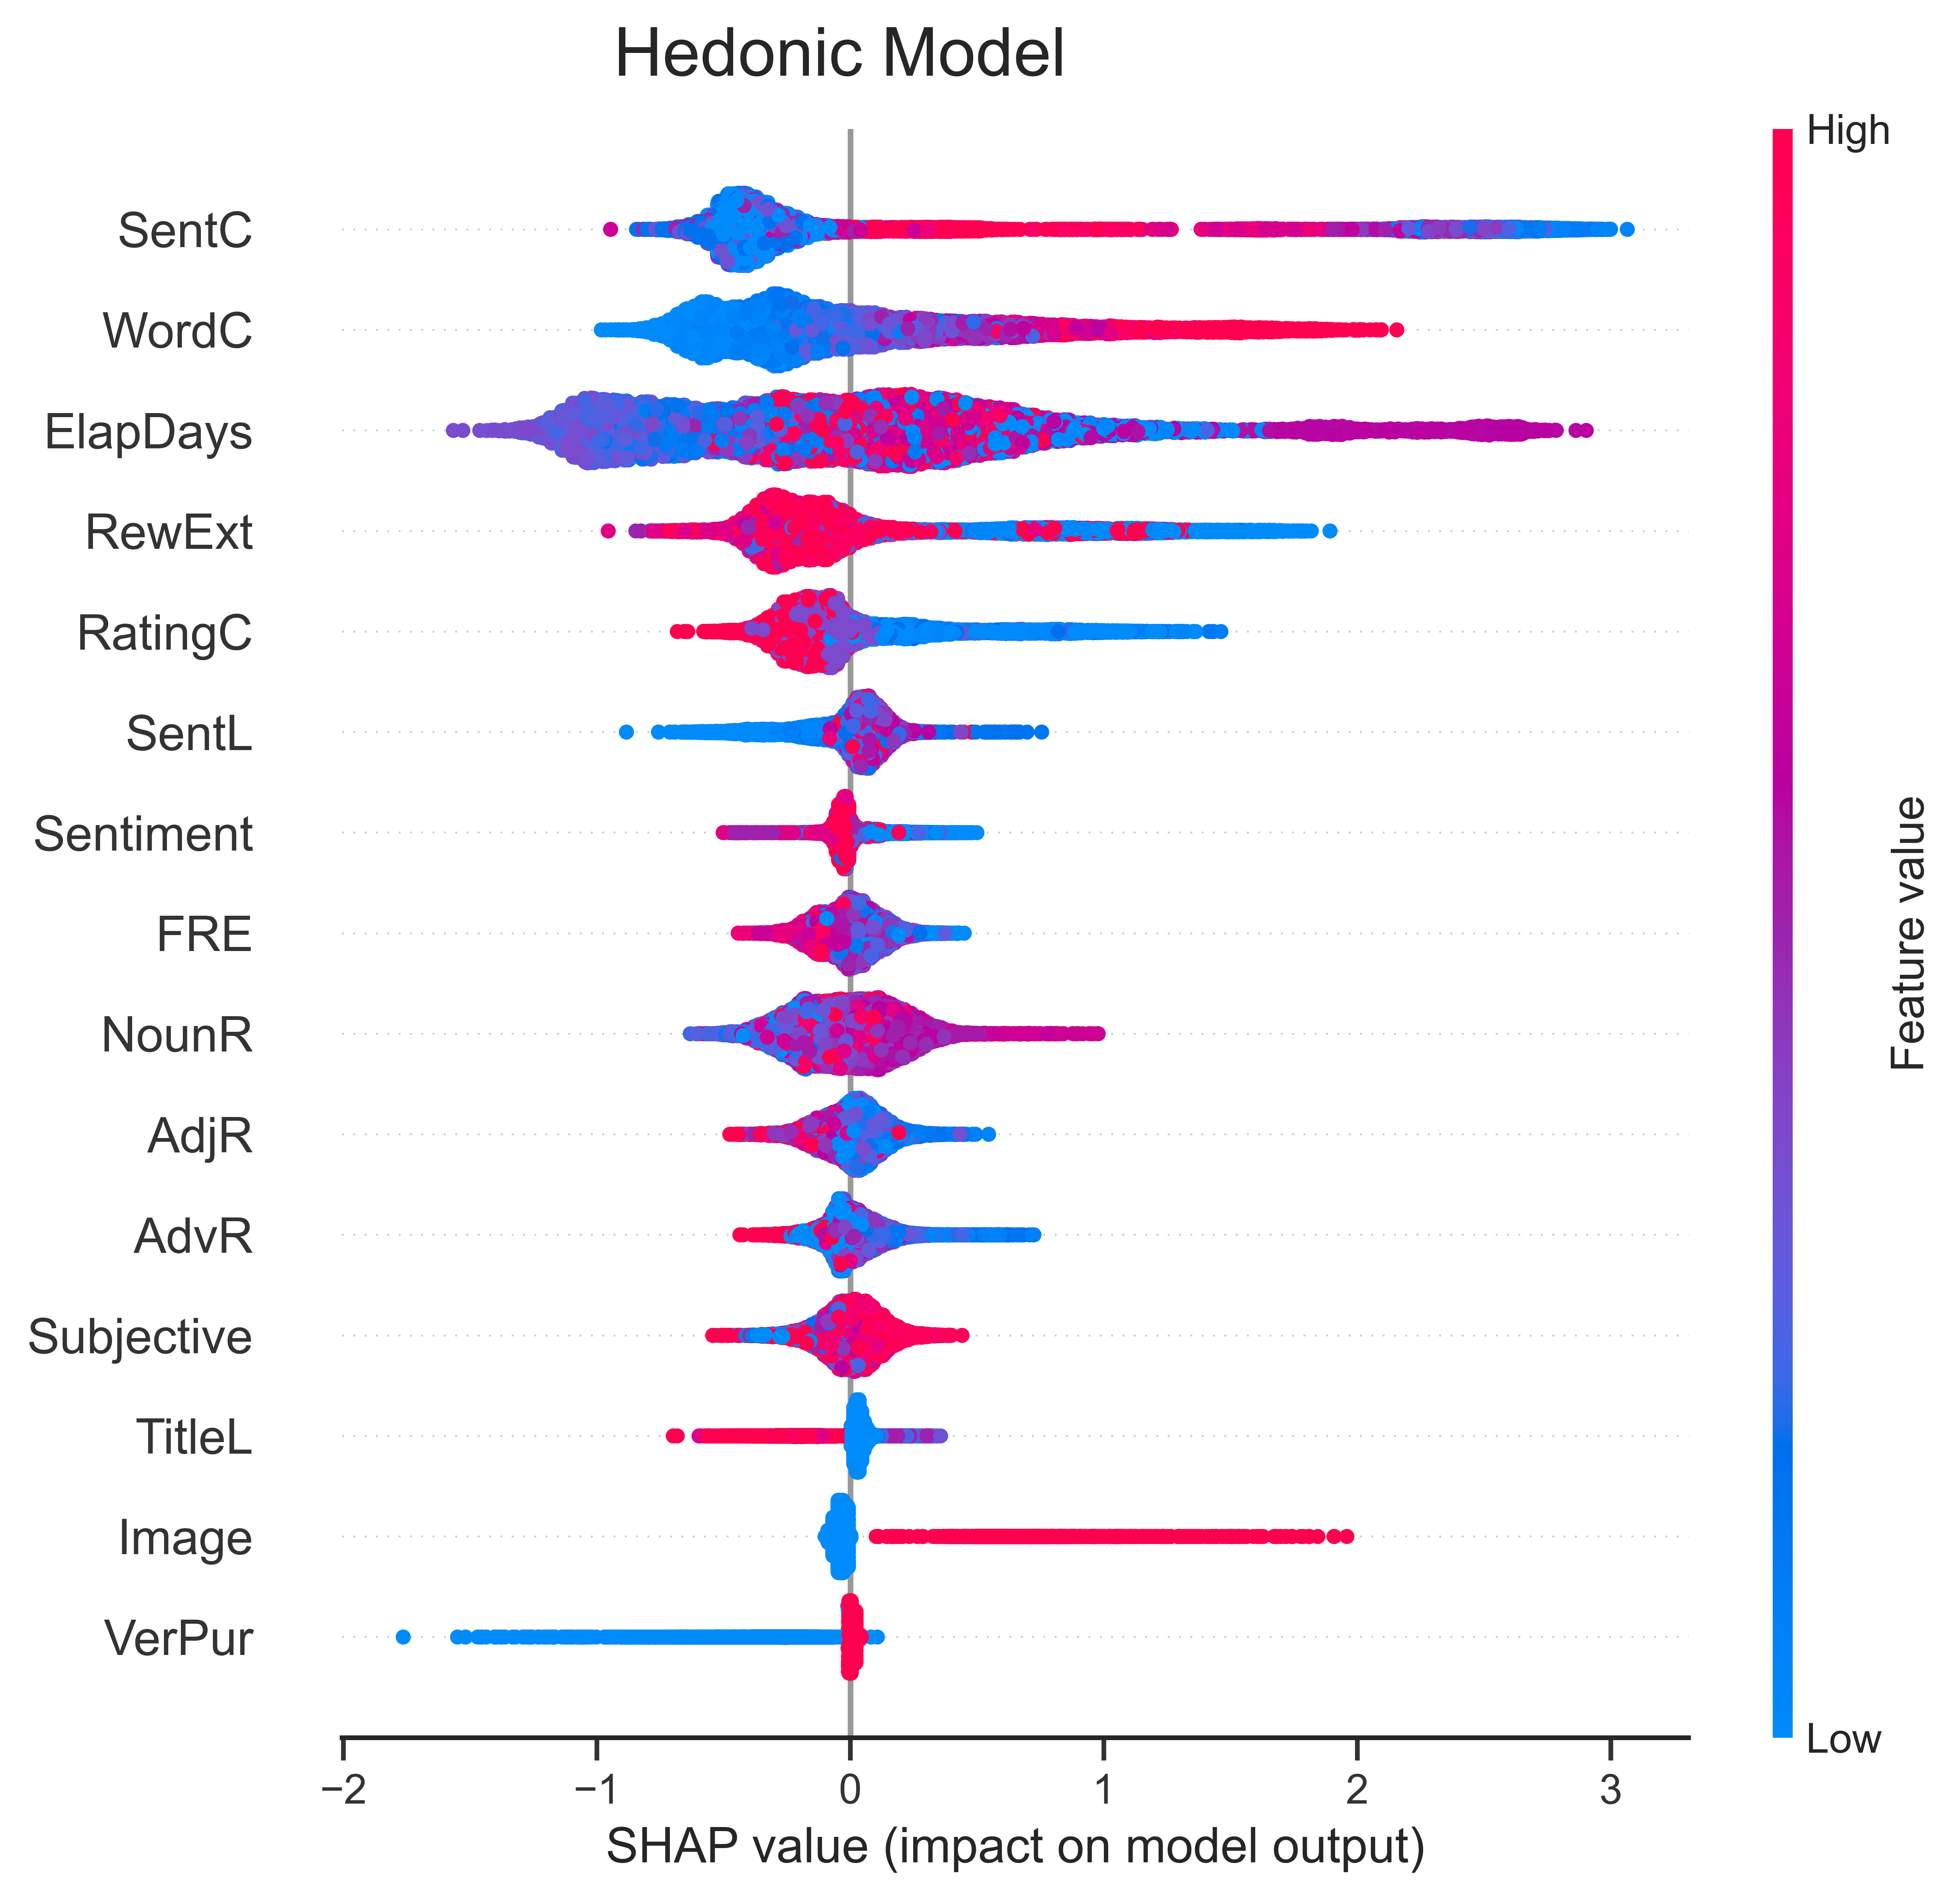

In [42]:

# Define the order of the features
order = ['SentC','WordC','ElapDays','RewExt','RatingC','SentL','Sentiment', 'FRE','NounR','AdjR', 'AdvR',
         'Subjective','TitleL', 'Image', 'VerPur']

# Create a mapping from column names to their indices
col2num = {col: i for i, col in enumerate(X_train_balanced.columns)}

# Ensure all columns in order exist in the DataFrame and map them to their indices
order = [col2num[col] for col in order if col in col2num]

# Create the beeswarm plot with the correct order
fig, ax = plt.subplots(figsize=(12, 8), dpi=800)  # Set figure size and DPI
shap.plots.beeswarm(shap_values,max_display=16, show=False, order=order) 

# Add the title above the plot with indentation
plt.suptitle('Hedonic Model', fontsize=18, ha='left', x=0.25, y=0.95)  

# Adjust the layout to create more space at the top for the title
plt.subplots_adjust(top=0.9) 

# Save the plot to a file with high resolution
plt.savefig('shap_beeswarm_plot_Hedonic.png', dpi=600, bbox_inches="tight") 

plt.show()



In [22]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_hyp)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_balanced)

[08:34:52] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [24]:
# Calculate the mean of the absolute SHAP values for each feature
average_shap_values_train = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for the features and their average SHAP values
shap_df_train = pd.DataFrame({
    'features': X_train.columns,
    'average_shap_value': average_shap_values_train
})

# Sort the DataFrame based on the average SHAP values
shap_hedonic = shap_df_train.sort_values(by='average_shap_value', ascending=False)

# Display the sorted DataFrame
print(shap_hedonic)

      features  average_shap_value
4        SentC            0.672134
7     ElapDays            0.603569
3        WordC            0.472079
0       RewExt            0.308731
14     RatingC            0.211206
10       NounR            0.143512
5        SentL            0.098468
2   Subjective            0.087515
11        AdjR            0.084024
13         FRE            0.082455
12        AdvR            0.071894
8        Image            0.064421
9       VerPur            0.059130
1    Sentiment            0.056506
6       TitleL            0.034350


In [25]:
shap_utilitarian = pd.read_csv ("/Users/paulahofmann/Documents/Coding/Online-Review/Models/shap_values_Utilitarian.csv")

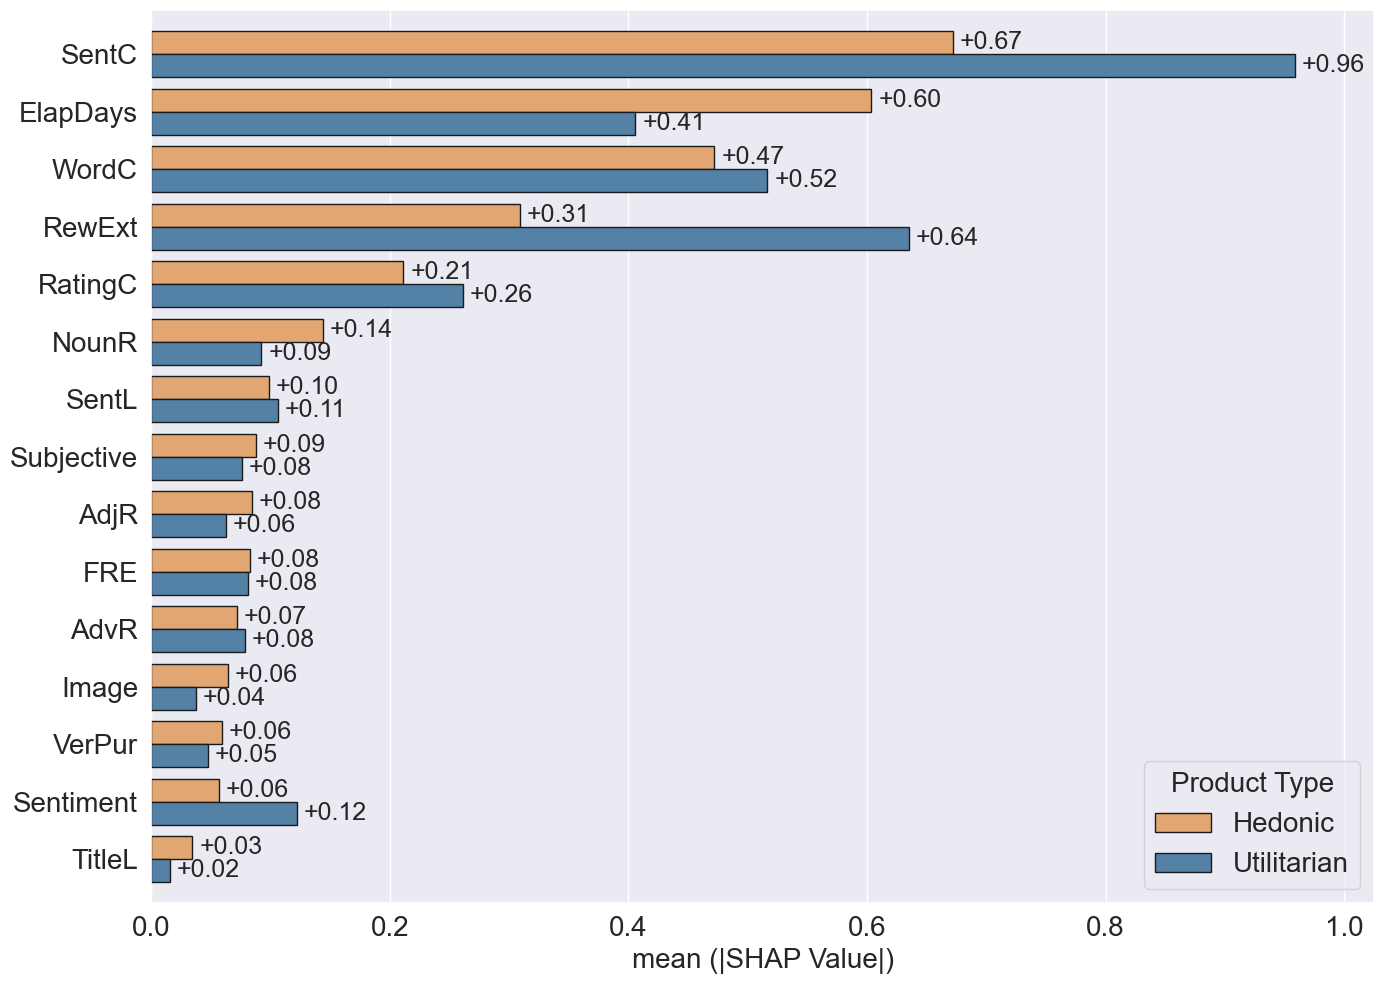

In [26]:
# Add category labels
shap_utilitarian['category'] = 'Utilitarian'
shap_hedonic['category'] = 'Hedonic'

sns.set_theme(style='darkgrid')
# Combine the DataFrames
shap_combined = pd.concat([shap_hedonic, shap_utilitarian])

# Sort by average_shap_value and select top 10 features
top_features = shap_combined.groupby('features')['average_shap_value'].mean().nlargest(16).index
shap_top_combined = shap_combined[shap_combined['features'].isin(top_features)]

# Create the plot
plt.figure(figsize=(14, 10))
ax = sns.barplot(data=shap_top_combined, x='average_shap_value', y='features', hue='category', width=0.8,orient='h', palette={"Utilitarian": "steelblue", "Hedonic": "sandybrown"},ec="k")


# Add the SHAP values beside each bar
for container in ax.containers:
    ax.bar_label(container, fmt='+%.2f', label_type='edge', padding=5, fontsize=18)

# Set x-scale maximum to 0.9
plt.xlim(0, 1.025)

# Set font sizes
plt.xlabel('mean (|SHAP Value|)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax.relim()
ax.autoscale_view()
ax.margins(y=0.025) 

# Remove y-axis label
plt.ylabel('')
plt.legend(title='Product Type', fontsize=20, title_fontsize=20)
plt.tight_layout()
plt.savefig('Mean_ShapValues.png', dpi=800)  # Save the figure with the desired DPI

plt.show()




[08:35:05] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


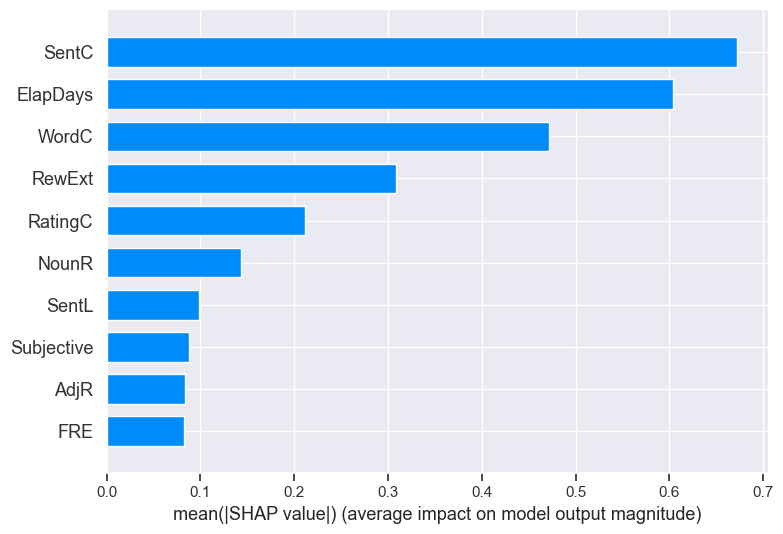

In [27]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_hyp)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_balanced)

# Plot the SHAP summary plot with beeswarm plot
shap.summary_plot(shap_values, X_train_balanced, plot_type="bar", show=True, max_display=10)
